In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
sklearn 0.20.2
scipy 1.1.0
matplotlib 3.0.2
tensorflow 1.13.1


**13장 – 합성곱 신경망**

_이 노트북은 13장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

흑백 이미지와 컬러 이미지를 그리기 위한 유틸리티 함수입니다:

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

텐서플로를 임포트합니다:

In [4]:
import tensorflow as tf

# 합성곱 층

imread에 관련된 경고는 사이킷런 0.20에서 수정될 예정입니다. 실제 실행에는 영향을 미치지 않으므로 무시합니다.

In [5]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

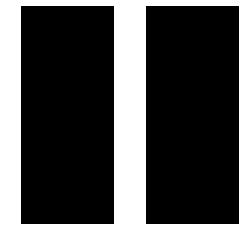

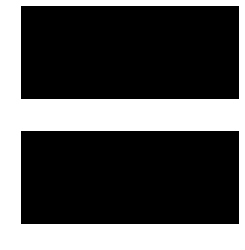

In [6]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [7]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_mapspl, strides=[1,1,1,1], padding="SAME")

In [8]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

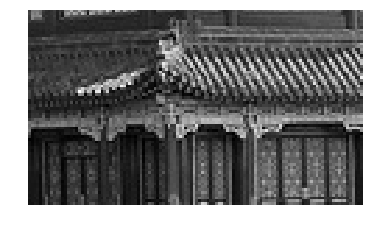

In [9]:
plot_image(images[0, :, :, 0])
save_fig("china_original_small", tight_layout=False)
plt.show()

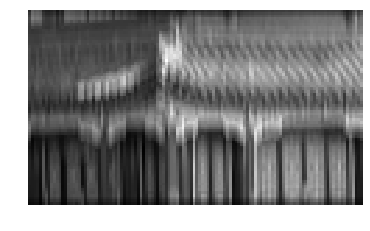

In [10]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

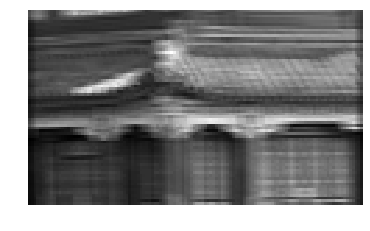

In [11]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

## 간단한 예제

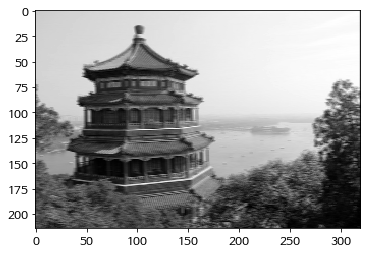

In [12]:
import numpy as np
# imread 함수와 관련된 경고는 scikit-learn 0.20에서 수정될 예정입니다.
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

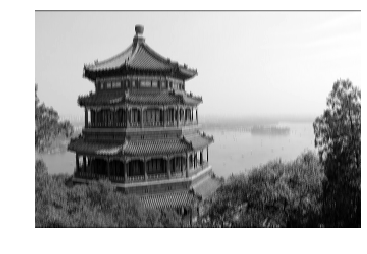

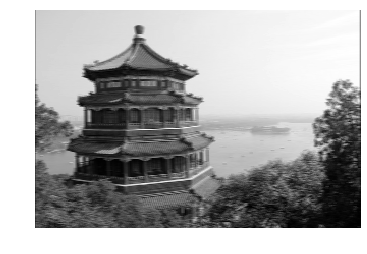

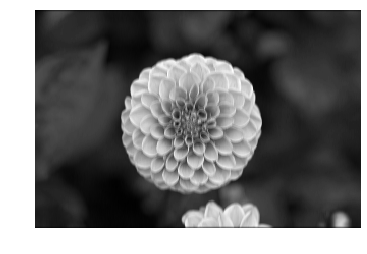

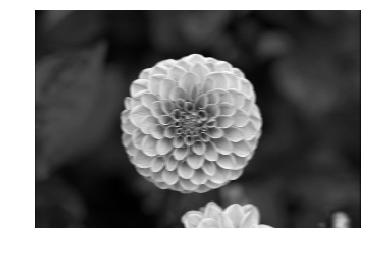

In [13]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

`tf.layers.conv2d()` 사용하기:

In [14]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [15]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

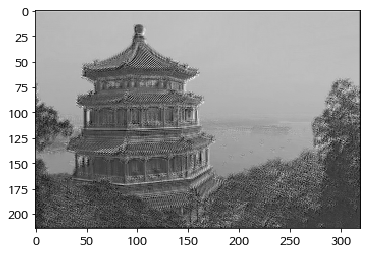

In [16]:
plt.imshow(output[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵 그리기
plt.show()

## VALID vs SAME 패딩

In [17]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [18]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# 풀링 층

In [19]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

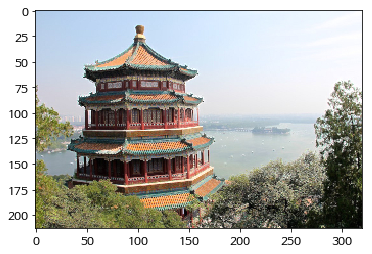

In [20]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # 첫 번째 이미지의 출력을 그리기
plt.show()

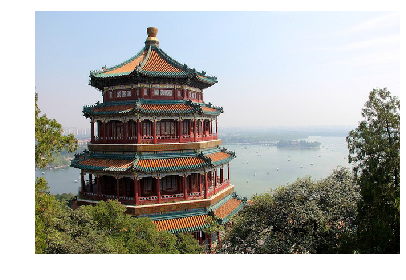

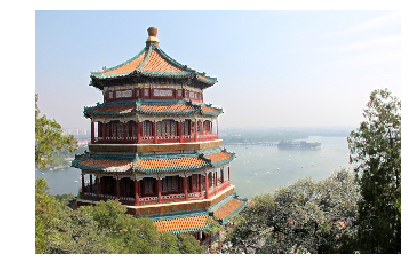

In [21]:
plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

In [22]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [23]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [24]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [25]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/")

In [26]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_val)

    acc_test = accuracy.eval(feed_dict={X: X_test,
                                        y: y_test})
    print("테스트 세트에서 최종 정확도:", acc_test)
        
    save_path = saver.save(sess, "./my_mnist_model")

0 배치 데이터 정확도: 0.99 검증 세트 정확도: 0.9784
1 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9872
2 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9808
3 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9874
4 배치 데이터 정확도: 0.99 검증 세트 정확도: 0.988
5 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9886
6 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9878
7 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9882
8 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9872
9 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9892
테스트 세트에서 최종 정확도: 0.9889


# 연습문제 해답

## 1. to 6.

부록 A 참조.

## 7. MNIST를 위한 고성능 CNN
_문제: 자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도를 달성해보세요._

다음 CNN은 위에서 만든 것과 비슷하지만 두 번째 합성곱 층에서 스트라이드 1을 사용하고 두 번째 합성곱 층 뒤에 25% 드롭아웃, 완전 연결층 뒤에 50% 드롭아웃을 적용한 것이 다릅니다. 그리고 조기 종료를 사용하여 훈련합니다. MNIST에서 약 99.2% 정확도를 달성합니다. 최고의 수준은 아니지만 나쁘지 않네요. 더 좋게 만들 수 있을까요?

In [27]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


데이터를 로드합니다:

In [28]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/")

`get_model_params()`는 모델의 상태(즉, 모든 변수의 값)를 얻어오고 `restore_model_params()` 함수는 이전 상태를 복원합니다. 이 함수들은 조기 종료의 속도를 높이기 위해 사용합니다. 즉 가장 좋은 모델을 디스크에 저장하는 대신 메모리에 저장합니다. 훈련이 끝난 후에 최상의 모델을 복원합니다.

In [29]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

모델을 훈련시켜 보죠! 조기 종료 구현은 다음과 같이 작동합니다:
* 100번 훈련 반복마다 검증 세트에서 모델을 평가합니다.
* 모델의 성능이 이전에 찾은 최상의 모델보다 낫다면 이 모델을 메모리에 저장합니다.
* 연속해서 100번의 평가 동안에도 진전이 없다면 훈련이 중지됩니다.
* 훈련이 끝난 후에 최상의 모델을 복원합니다.

In [30]:
n_epochs = 1000
batch_size = 50

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("에포크 {}, 배치 데이터 정확도: {:.4f}%, 검증 세트 정확도: {:.4f}%, 검증 세트에서 최선의 손실: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("조기 종료!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    # GPU 메모리가 부족해서 5000개만 평가했습니다. CPU를 사용하거나 GPU 메모리가 크다면 테스트 세트 전체를 평가해 보세요.
    acc_test = accuracy.eval(feed_dict={X: X_test[:5000],
                                        y: y_test[:5000]})
    print("테스트 세트에서 최종 정확도:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

에포크 0, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.3800%, 검증 세트에서 최선의 손실: 0.052908
에포크 1, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.8800%, 검증 세트에서 최선의 손실: 0.045351
에포크 2, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.8600%, 검증 세트에서 최선의 손실: 0.041169
에포크 3, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.9400%, 검증 세트에서 최선의 손실: 0.035900
에포크 4, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.9400%, 검증 세트에서 최선의 손실: 0.035900
에포크 5, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.7600%, 검증 세트에서 최선의 손실: 0.035900
에포크 6, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0000%, 검증 세트에서 최선의 손실: 0.035900
에포크 7, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0800%, 검증 세트에서 최선의 손실: 0.035900
에포크 8, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.1200%, 검증 세트에서 최선의 손실: 0.035900
에포크 9, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0400%, 검증 세트에서 최선의 손실: 0.035900
에포크 10, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.1200%, 검증 세트에서 최선의 손실: 0.035900
조기 종료!
테스트 세트에서 최종 정확도: 0.9844


## 8.  Inception v3를 사용하여 사이즈가 큰 이미지 분류하기

### 8.1.
_문제: 여러 종류의 동물 이미지를 내려받으세요. `matplotlib.image.mpimg.imread()` 함수나 `scipy.misc.imread()` 함수를 사용해 파이썬에서 이미지를 로드하세요. 이미지 크기를 바꾸고 잘라내어 299 × 299픽셀로 만들고, 알파 채널을 포함하지 않고 세 개의 채널(RGB)만 있는지 확인합니다. Inception에서 훈련에 사용한 이미지들은 -1.0에서 1.0 사이의 값을 가지도록 전처리되었습니다. 따라서 여기서 준비한 이미지들도 마찬가지로 전처리되어야 합니다._

In [31]:
width = 299
height = 299
channels = 3

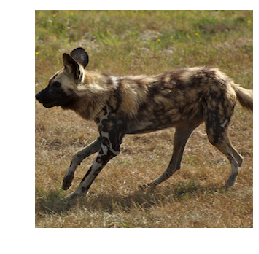

In [32]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

[0, 1] 범위가 아니라 (미리 학습된 인셉션 모델처럼) [-1, 1] 범위를 가지도록 만듭니다.

In [33]:
test_image = 2 * test_image - 1

## 8.2.
_문제: 가장 최근에 미리 훈련된 Inception v3 모델을 내려받습니다. 체크포인트는 https://goo.gl/XgKiSi 에서 내려받을 수 있습니다. 클래스 이름의 목록은 https://goo.gl/brXRtZ 에 있습니다. 하지만 이 목록 맨 위에 background 클래스를 추가해야 합니다._

In [34]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [35]:
fetch_pretrained_inception_v3()

In [36]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [37]:
class_names = ["background"] + load_class_names()

In [38]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

## 8.3.
_문제: 다음과 같이 `inception_v3()` 함수를 호출해 Inception v3 모델을 만듭니다. 반드시 `inception_v3_arg_scope()` 함수로 생성한 이름 범위 안에서 만들어야 합니다. 또한 다음과 같이 is_training=False와 num_classes=1001로 지정해야 합니다._

In [39]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

### 8.4.
_문제: 세션을 열고 Saver를 사용해 앞서 내려받은 미리 훈련된 모델의 체크포인트를 복원하세요._

In [40]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # ...

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


### 8.5.
_문제: 모델을 실행해서 준비한 이미지를 분류해보세요. 이미지마다 상위 다섯 개 예측을 추정 확률과 함께 출력해보세요. 모델이 얼마나 정확한가요?_

In [41]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [42]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

276

In [43]:
class_names[most_likely_class_index]

'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus'

In [44]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 93.13%
hyena, hyaena: 2.57%
European fire salamander, Salamandra salamandra: 0.06%
bearskin, busby, shako: 0.05%
swimming trunks, bathing trunks: 0.05%


이 이미지에서 매우 정확도가 높습니다. 즉 높은 신뢰도로 정확하게 예측합니다.

## 9. 대규모 이미지 분류를  위한 전이 학습

### 9.1.
_문제: 클래스마다 최소한 100개의 이미지가 들어 있는 훈련 세트를 만드세요. 예를 들어 위치에 따라(해변, 산, 도심 등) 자신의 사진을 분류하거나, 꽃 데이터셋(https://goo.gl/EgJVXZ )이나 MIT의 장소 데이터셋(http://places.csail.mit.edu/) (등록이 필요하고 매우 큽니다) 같은 기존의 데이터셋을 사용할 수도 있습니다._

꽃 데이터셋을 사용해 보죠. 먼저 데이터를 다운로드합니다:

In [45]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [46]:
fetch_flowers()

`flower_photos` 디렉토리의 서브 디렉토리마다 해당 클래스의 이미지가 들어 있습니다. 클래스 목록을 확인해 보겠습니다:

In [47]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

클래스별로 모든 이미지 파일의 경로를 리스트로 만듭니다:

In [48]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

실행할 때마다 결과를 일정하게 만들기 위해 이미지 경로를 소팅합니다:

In [49]:
for paths in image_paths.values():
    paths.sort()    

클래스별로 처음 몇 개 이미지를 확인해 보겠습니다:

클래스: daisy


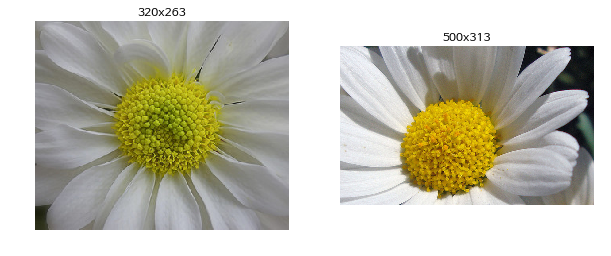

클래스: dandelion


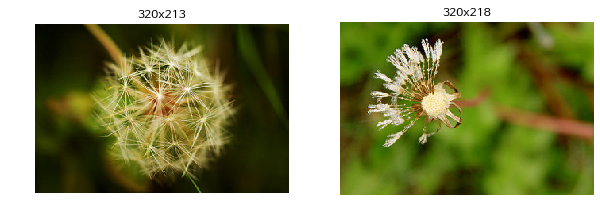

클래스: roses


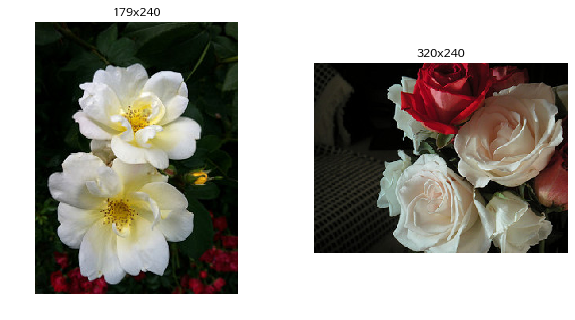

클래스: sunflowers


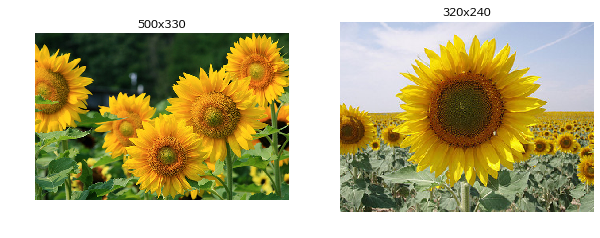

클래스: tulips


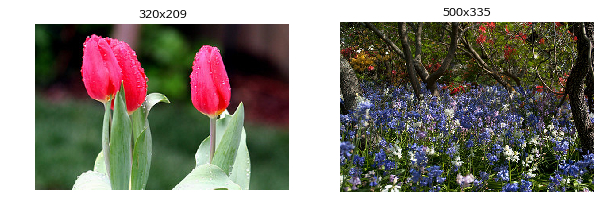

In [50]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("클래스:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

이미지 크기가 서로 다르고 어떤 것은 어려워 보입니다(가령, 두 번째 튤립 이미지).

### 9.2.
_문제: 전처리 단계에서 이미지 크기를 줄이고 잘라서 299 × 299 크기로 만들고 무작위성을 추가하여 데이터 증식을 하세요._

먼저 넘파이와 사이파이를 사용해 구현해 보겠습니다:

* 넘파이 슬라이싱을 사용해 이미지를 자릅니다.
* 넘파이 `fliplr()` 함수를 사용해 이미지를 수평으로 반전합니다(50% 확률로).
* 사이파이 `imresize()` 함수로 확대합니다.
  * `imresize()` 함수는 파이썬 이미지 라이브러리(PIL)을 사용합니다.
  
회전 등과 같은 다른 이미지 조작 함수는 [사이파이 문서](https://docs.scipy.org/doc/scipy/reference/ndimage.html)나 [이 페이지](http://www.scipy-lectures.org/advanced/image_processing/)를 참고하세요.

In [51]:
# from scipy.misc import imresize
from PIL import Image

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """데이터 증식을 위해 이미지를 랜덤하게 자르거나 확대합니다."""

    # 먼저 이미지에서 타깃 크기에 맞는 최대 비율의 네모 상자 크기를 찾습니다.
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # 이 상자의 크기를 랜덤한 비율로 줄입니다(1.0에서 1.0+`max_zoom` 사이의 난수로 나눕니다).
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # 다음 이 상자가 놓일 이미지의 위치를 랜덤하게 선택합니다.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # 이제 이미지를 자릅니다.
    image = image[y0:y1, x0:x1]

    # 50% 확률로 이미지를 수평으로 반전시킵니다.
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # 타깃 크기에 맞도록 이미지 크기를 변경합니다.
#     image = imresize(image, (target_width, target_height))
    image = np.array(Image.fromarray(image).resize((target_width, target_height)))
    
    # 마지막으로 컬러 값이 0.0에서부터 1.0 사이의 32비트 값이 되도록 만듭니다.
    return image.astype(np.float32) / 255

노트: 테스트할 때에는 전처리 단계가 가능한 간단해야 합니다. 신경망에 이미지를 주입하기 위해 꼭 필요한 것만 수행합니다. 위 함수에 `training` 매개변수를 추가해서 `False`일 때는 전처리가 기본적인 것만 수행하도록 만들 수 있습니다(즉, 이미지 반전을 제외하고 이미지 중앙 부분만 자릅니다).

결과 이미지를 확인해 보겠습니다:

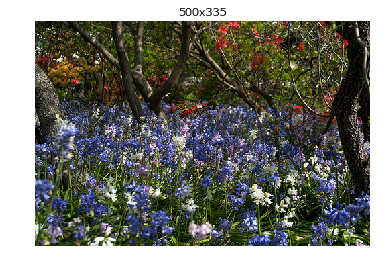

In [52]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

위 함수를 적용하면:

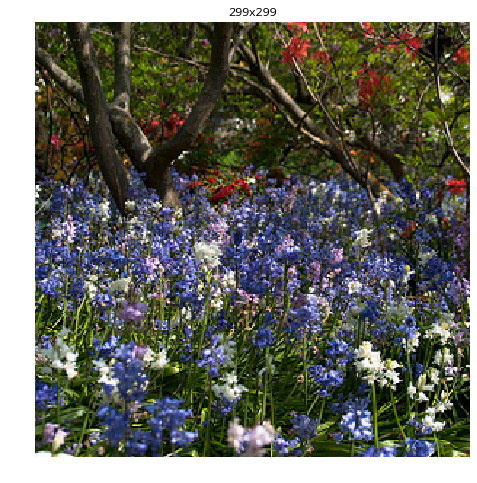

In [53]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

같은 이미지를 사용해 랜덤하게 생성된 몇 개를 더 확인해 보겠습니다:

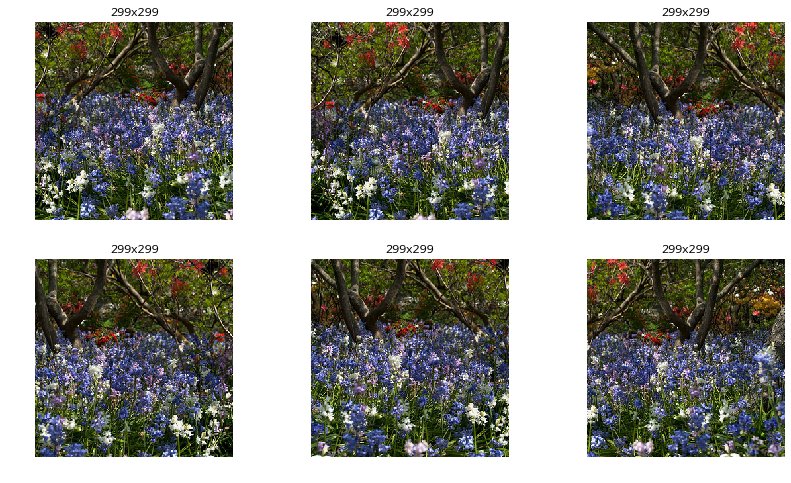

In [54]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

좋네요!

또 다른 방법으로는 텐서플로의 `tf.image` 모듈에 있는 함수(전체 함수는 [API 문서](https://www.tensorflow.org/api_docs/python/)를 참고하세요)를 사용해 직접 이미지 전처리 단계를 구현하는 것도 가능합니다. 이 함수는 위와 매우 비슷하지만 실제로 이미지 변환을 수행하지 않고 그래프가 실행될 때 변환을 할 수 있는 텐서플로 연산을 만든다는 것이 다릅니다.

In [55]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """데이터 증식을 위해 이미지를 랜덤하게 자르거나 확대합니다."""

    # 먼저 이미지에서 타깃 크기에 맞는 최대 비율의 네모 상자 크기를 찾습니다.
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # 이 상자의 크기를 랜덤한 비율로 줄입니다(1.0에서 1.0+`max_zoom` 사이의 난수로 나눕니다).
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = 채널 개수

    # 다음 이 상자가 놓일 이미지의 위치를 랜덤하게 선택합니다.
    image = tf.random_crop(image, box_size)

    # 50% 확률로 이미지를 수평으로 반전시킵니다.
    image = tf.image.random_flip_left_right(image)

    # resize_bilinear 함수는 4D 텐서를 기대하기 때문에 (이미지 배치) 첫 번째 차원을 추가해야 합니다.
    image_batch = tf.expand_dims(image, 0)

    # 타깃 크기에 맞도록 이미지 크기를 변경합니다. 이 함수는 float32 텐서를 반환합니다.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # 이미지 하나를 선택하고 컬러 값이 0.0에서부터 1.0 사이의 32비트 값이 되도록 만듭니다.
    return image

이 함수를 테스트해 보죠!

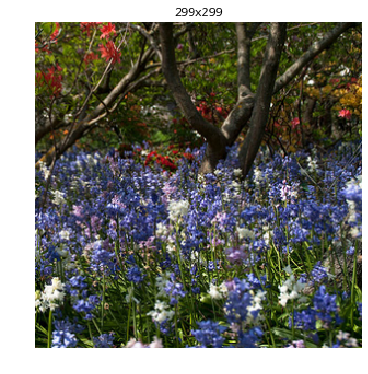

In [56]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

아주 잘 되네요!

### 9.3.
_문제: 이전 연습문제의 미리 훈련된 Inception v3 모델을 사용해 병목층(즉, 출력층 직전의 마지막 층)까지의 모든 층을 동결하고, 이 분류 문제에 맞는 적절한 출력 개수를 가진 출력층으로 바꾸세요(예를 들어 꽃 데이터셋은 다섯 개의 상호 배타적인 클래스를 가지고 있으므로 출력층은 다섯 개의 뉴런을 가져야 하고 소프트맥스 활성화 함수를 사용해야 합니다)._

inception v3 그래프를 다시 불러오겠습니다. 이번에는 텐서플로가 이 신경망을 훈련할지 말지 알려주기 위해 `training` 플레이스홀더를 사용합니다(드롭아웃과 배치 정규화 같은 연산을 위해서).

In [57]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

그래프에서 새로운 출력층을 추가할 지점을 찾아야 합니다. 이는 현재 출력층 직전의 층입니다. 이 층을 찾는 한가지 방법은 출력층의 입력을 조회하는 것입니다:

In [58]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

아 이건 출력층의 일부입니다(편향 덧셈). 그래프를 거꾸로 계속 따라가 보겠습니다:

In [59]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/Conv2D:0' shape=(?, 1, 1, 1001) dtype=float32>

이것도 출력층의 일부입니다. 인셉션 층의 마지막 층입니다(텐서보드에서 시각화해 보면 확실히 알 수 있습니다). 계속해서 거꾸로 따라가 봅니다:

In [60]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

아하! 이거네요. 드롭아웃 층의 출력입니다. 이 층이 Inception v3 네트워크에 있는 출력층 직전의 마지막 층입니다. 여기에 새로운 층을 쌓아야 합니다. 사실 이 층을 찾는 더 간단한 방법이 있는데 `inception_v3()` 함수는 각 층의 종료 지점을 딕셔너리로 리턴해줍니다:

In [61]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

여기에서 볼 수 있듯이 `"PreLogits"`가 정확히 우리가 원하는 곳입니다:

In [62]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

`tf.squeeze()` 함수를 사용해 두 번째, 세 번째 차원을 제거합니다:

In [63]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

그런 다음 이 층 위에 최종 완전 연결층을 추가합니다:

In [64]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

마지막으로 필요한 연산을 추가합니다:

* 타깃(`y`)을 위한 플레이스홀더
* 분류 작업에 사용되는 크로스엔트로피 손실 함수
* 비용 함수를 최소화시키는 훈련 연산을 만드는 옵티마이저
* 모델의 정확도를 측정할 몇 개의 연산
* 마지막으로 초기화 연산와 `Saver` 객체

한 가지 중요한 점이 있습니다. 출력층만 훈련시켜야하므로(다른 모든 층은 동결입니다) 옵티마이저의 `minimize()` 메서드에 훈련시킬 변수 목록을 전달해야 합니다:

In [65]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

In [66]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

새로운 출력층을 추가하기 전에 `inceptioin_saver`를 만든 것을 주목하세요. 이를 사용해 이전에 훈련된 모델 상태를 복원하는데 새로운 변수를 복원하려 시도하는 것을 원치 않습니다(새로운 변수를 알지 못하기 때문에 실패할 것입니다). 두 번째 `saver`는 사전에 학습된 변수와 새로운 변소를 포함한 최종 모델을 저장하는데 사용됩니다.

### 9.4.
_문제: 준비한 데이터셋을 훈련 세트와 테스트 세트로 나누세요. 훈련 세트에서 모델을 훈련시키고 테스트 세트에서 모델을 평가해보세요._

먼저 클래스를 문자열대신 숫자로 표현합니다:

In [67]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

파일 경로/클래스 쌍으로 리스트가 구성되어 있으면 데이터를 섞기가 용이합니다:

In [68]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

다음 데이터셋을 섞고 훈련 세트와 테스트 세트로 나눕니다:

In [69]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

훈련 세트에서 처음 3개의 샘플을 확인해 보죠:

In [70]:
flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4)]

그다음 이미지를 전처리하는 함수를 만듭니다. 이 함수는 테스트 세트를 전처리할 때도 사용하고 훈련할 때는 배치를 만들 수도 있습니다. 여기서는 간단하게 넘파이/사이파이 구현을 사용하겠습니다:

In [71]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [72]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [73]:
X_batch.shape

(4, 299, 299, 3)

In [74]:
X_batch.dtype

dtype('float32')

In [75]:
y_batch.shape

(4,)

In [76]:
y_batch.dtype

dtype('int32')

잘 된 것 같습니다. 이제 이 함수를 사용해 테스트 세트를 준비해 보죠:

In [77]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [78]:
X_test.shape

(734, 299, 299, 3)

같은 방식으로 테스트 세트를 준비할 수 있지만 이미지마다 하나의 데이터만 증식합니다. 대신 훈련하는 동안 그때 그때 훈련 배치를 생성하는 것이 더 좋습니다. 그래야 이미지마다 변종 데이터가 많아 데이터 증식의 효과를 누릴 수 있습니다.

이제 신경망을 훈련시킬 준비를 마쳤습니다(조금 더 정확하게는 출력층만 추가했고 다른 모든 층은 동결되었습니다). 이 훈련은 매우 오랜 시간이 걸립니다.

In [79]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("에포크", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  훈련 정확도:", acc_train)

        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
에포크 0.........................................................................  훈련 정확도: 0.55
에포크 1.........................................................................  훈련 정확도: 0.575
에포크 2.........................................................................  훈련 정확도: 0.525
에포크 3.........................................................................  훈련 정확도: 0.7
에포크 4.........................................................................  훈련 정확도: 0.575
에포크 5.........................................................................  훈련 정확도: 0.575
에포크 6.........................................................................  훈련 정확도: 0.625
에포크 7.........................................................................  훈련 정확도: 0.55
에포크 8.........................................................................  훈련 정확도: 0.6
에포크 9.........................................................................  훈

In [80]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("테스트 세트에서 최종 정확도를 계산합니다 (시간이 좀 걸립니다)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("테스트 정확도:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
테스트 세트에서 최종 정확도를 계산합니다 (시간이 좀 걸립니다)...
테스트 정확도: 0.70573866


네 68.8% 정확도는 좋지 않습니다(사실 이는 나쁜 편입니다). 하지만 이는 출력층을 제외하고 모든 층을 동결하여 10번의 에포크만 실행한 것입니다. GPU를 가지고 있다면 더 오랫동안 훈련을 시켜보세요(가령, 조기 종료 기법을 사용해). 이미지 전처리 함수를 개선하여 이미지를 더 다양하게 변형시킬 수도 있습니다(가령, 명암이나 색조를 바꾸거나 이미지를 조금 회전시킵니다). 이렇게 하면 95% 정확도 이상을 달성할 수 있습니다. 조금 더 심각하게 파고들고 싶다면 96% 정확도를 달성한 [훌륭한 이 포스트](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html)에서 자세한 내용을 참고하세요.

## 10.
_문제: 텐서플로의 딥드림 설명서(https://goo.gl/4b2s6g )를 살펴보세요. CNN으로 학습한 패턴을 시각화하거나 딥러닝을 사용해 그림을 생성하는 재미있는 방법을 배울 수 있습니다._

노트북을 다운로드하고 설명을 따라하면 됩니다. 더 재미있게 만들려면 여러개의 이미지를 시리즈로 만들고 딥드림 알고리즘을 반복적으로 실행하면서 확대해 보세요. [ffmpeg](https://ffmpeg.org/)와 같은 도구를 사용하면 이런 이미지로 영상을 만들 수 있습니다. 예를 들어 [DeepDream video](https://www.youtube.com/watch?v=l6i_fDg30p0)는 제가 만든 것입니다. 보면 알 수 있지만 금방 호러물이 됩니다. ;-) 웹에서 쉽게 (훨씬 예술적인) [비슷한 영상](https://www.youtube.com/results?search_query=+deepdream)을 많이 찾을 수 있습니다.